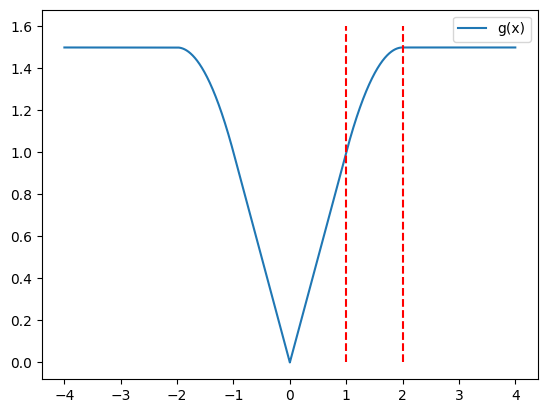

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import math

def func(theta, gamma1, gamma2):
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

gamma1, gamma2 = 1, 2
x = np.linspace(-4, 4, 100000)
y = [func(i, gamma1, gamma2) for i in x]

plt.plot(x, y, label='g(x)')
plt.vlines(1, 0, 1.6, colors = "r", linestyles = "dashed")
plt.vlines(2, 0, 1.6, colors = "r", linestyles = "dashed")
plt.legend()
plt.show()

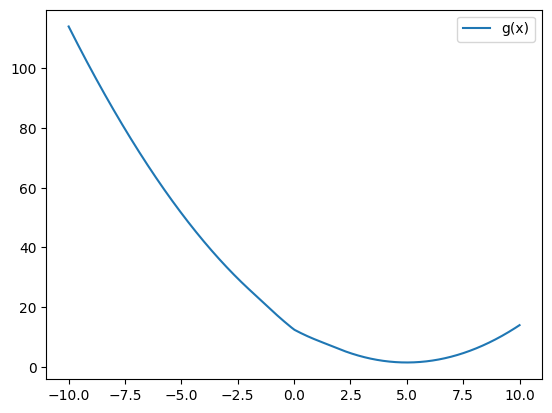

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import math

def func(theta, gamma1, gamma2):
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

gamma1, gamma2 = 1, 2
x = np.linspace(-10, 10, 100000)
y = [func(i, gamma1, gamma2) + 0.5 * (i - 5) * (i - 5) for i in x]

plt.plot(x, y, label='g(x)')
plt.legend()
plt.show()

In [91]:
import matplotlib.pyplot as plt
import numpy as np
import math

rand_generator = np.random.default_rng(seed=0)

gamma1, gamma2 = 5, 10
def penalty_func(theta, gamma1=gamma1, gamma2=gamma2):
    """
    theta: scalar, input variable
    """
    if abs(theta) <= gamma1:
        return abs(theta)
    elif abs(theta) <= gamma2:
        return (2 * gamma2 * abs(theta) - theta * theta - gamma1 * gamma1) \
        / (2 * (gamma2 - gamma1))
    else:
        return (gamma1 + gamma2) / 2

# construct A, x_solution, b
m, n = 2 ** 10, 2 ** 12
# A: shape [m, n], mean 0, variance 1 / 2n
A = rand_generator.normal(0, 1 / math.sqrt(n), (m, n))
x_solution = np.zeros(n)
random_positions = rand_generator.choice(range(n), size=160, replace=False)
for i in random_positions:
    x_solution[i] = rand_generator.choice([-1, 1])
b = np.dot(A, x_solution) + rand_generator.normal(0, 1 / math.sqrt(10**4), m)

# parameter of non-convex penalty function
mu = 0.1 * np.linalg.norm(np.dot(A.transpose(), b), ord=np.inf)  # coeff of penalty function
alpha_max, alpha_min = 10 ** 30, 1 / 10 ** 30
eta = 2
sigma = 0.01

def main_func(theta):
    """
    theta: vector, input variable
    """
    fx = 0.5 * (np.linalg.norm(np.dot(A, theta) - b) ** 2)
    gx = sum([penalty_func(i) for i in theta])
    return fx + mu * gx

def solve_sub(ut, alpha):
    negative = True if ut < 0 else False
    ut = abs(ut)

    solution_set = []
    # (0, gamma1)
    if ut + mu / alpha <= 0:
        solution_set.append(0)
    elif ut + mu / alpha <= gamma1:
        solution_set.append(ut + mu / alpha)
    else:
        solution_set.append(gamma1)
    # (gamma1, gamma2)
    a = 1 - mu / (alpha * (gamma2 - gamma1))
    z = (ut - mu / alpha * gamma2 / (gamma2 - gamma1)) / a
    if a <= 0:
        solution_set.append(gamma1)
        solution_set.append(gamma2)
    else:
        if z <= gamma1:
            solution_set.append(gamma1)
        elif z <= gamma2:
            solution_set.append(z)
        else:
            solution_set.append(gamma2)
    # (gamma2, +∞)
    if ut < gamma2:
        solution_set.append(gamma2)
    else:
        solution_set.append(ut)
    
    def sub_function(theta):
        return 0.5 * (theta - ut) ** 2 + mu / alpha * penalty_func(theta)

    solution = min(solution_set, key=sub_function)
    # print(solution_set, [sub_function(i) for i in solution_set], solution)
    solution = - solution if negative else solution

    return solution


xt = np.ones(n)  # initial guess of xt
M_queue = [main_func(xt)] * 5
for i in range(100):
    if i != 0:
        # bb step size
        st = xt - x_old
        alpha = np.linalg.norm(np.dot(A, st)) ** 2 / (np.linalg.norm(st) ** 2)
        assert alpha > alpha_min and alpha < alpha_max
        # print(f"alpha: {alpha}")
    else:
        alpha = 10

    x_old = xt
    
    for _ in range(100):
        ut = xt - np.matmul(A.transpose(), np.matmul(A, xt) - b)
        xt = np.array([solve_sub(i, alpha=alpha) for i in ut])

        xt_func = main_func(xt)
        max_func = max(M_queue)

        if xt_func <= max_func - sigma * alpha * (np.linalg.norm(xt - x_old) ** 2) / 2:
            break

        alpha *= eta
    
    M_queue.pop(0)
    M_queue.append(main_func(xt))
    print(M_queue)

    # termination condition
    if np.linalg.norm(xt - x_solution) < 1:
        break

    print(np.linalg.norm(xt - x_solution))


[723.5376397151089, 723.5376397151089, 723.5376397151089, 723.5376397151089, 344.04480325923805]
59.58314458119022
[723.5376397151089, 723.5376397151089, 723.5376397151089, 344.04480325923805, 324.65427816756545]
60.44337506102225
[723.5376397151089, 723.5376397151089, 344.04480325923805, 324.65427816756545, 312.6392123283015]
61.539186300723884
[723.5376397151089, 344.04480325923805, 324.65427816756545, 312.6392123283015, 344.0340313767633]
62.8961283110152
[344.04480325923805, 324.65427816756545, 312.6392123283015, 344.0340313767633, 371.5731453866896]
64.29860724980087
[324.65427816756545, 312.6392123283015, 344.0340313767633, 371.5731453866896, 9.340554938816737e+18]
2894351881.9680233
[312.6392123283015, 344.0340313767633, 371.5731453866896, 9.340554938816737e+18, 1.0794297796255992e+37]
3.1102853546647025e+18
[344.0340313767633, 371.5731453866896, 9.340554938816737e+18, 1.0794297796255992e+37, 1.3655692196810035e+55]
3.49823618588763e+27
[371.5731453866896, 9.340554938816737e+18,

KeyboardInterrupt: 